In this notebook we want to predict Bitcoin price using python and machin learning (LSTM network).

So first of all we will import the libraries that we want to use in this notebook

In [ ]:
!pip install yfinance

In [ ]:
!pip install download

In [ ]:
!pip install keras

In [ ]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=8acd449c16bf4751a48422848ca3a2bd3a15ea06890d90a0aa498da16b2bfdb9
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
import matplotlib.pyplot as plt

In [ ]:
import yfinance as yf
from datetime import datetime

In [ ]:
# Set the start and end dates
start = datetime(2014,1,1)
end = datetime.now().date().isoformat()
symbol = 'BTC-USD'

In [ ]:
df = yf.download(symbol,start=start,end = end)
df.shape

[*********************100%***********************]  1 of 1 completed


(3744, 6)

In [ ]:
# Resample the data to hourly frequency
#df = df.resample('H').ffill()  # Forward fill to handle missing hours

In [ ]:
# Checking the shape of our original data frame
df.shape

(3744, 6)

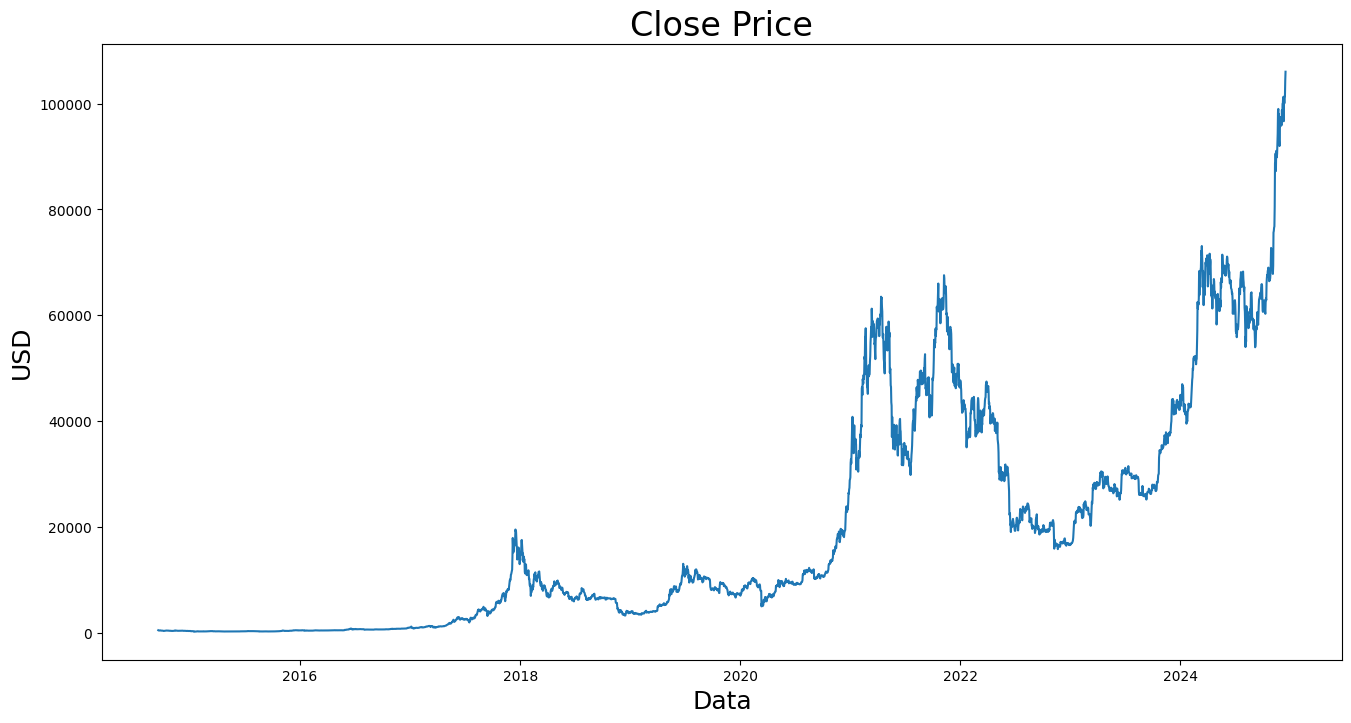

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

In [ ]:
print(df.columns)  # Check the column names

MultiIndex([('Adj Close', 'BTC-USD'),
            (    'Close', 'BTC-USD'),
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


In [ ]:
print("Columns in DataFrame:", df.columns.tolist())

Columns in DataFrame: [('Adj Close', 'BTC-USD'), ('Close', 'BTC-USD'), ('High', 'BTC-USD'), ('Low', 'BTC-USD'), ('Open', 'BTC-USD'), ('Volume', 'BTC-USD')]


In [ ]:
#Creat a new dataframe with only Close Price
data = df.iloc[:, df.columns.get_loc('Close')]
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len


2996

Now that we have our close price values in a seprated dataframe we can start normalization our data.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00263795],
       [0.00232719],
       [0.00204714],
       ...,
       [0.95600681],
       [0.9836467 ],
       [1.        ]])

In [ ]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.00263795, 0.00232719, 0.00204714, 0.00218042, 0.00208516,
       0.00211663, 0.00243443, 0.00231552, 0.00220564, 0.00213811,
       0.00209177, 0.00188073, 0.00186453, 0.00197296, 0.00194151,
       0.0018608 , 0.0017138 , 0.00142429, 0.00134535, 0.00143575,
       0.00149345, 0.00165172, 0.0017659 , 0.00173317, 0.00174013,
       0.00189365, 0.00200574, 0.00210452, 0.00204692, 0.00193151,
       0.00194286, 0.00201545, 0.00199754, 0.00193424, 0.00196853,
       0.00193719, 0.00170346, 0.00170278, 0.00159816, 0.00166838,
       0.00165218, 0.00169591, 0.00148782, 0.00157959, 0.00151361,
       0.00139484, 0.00139619, 0.00141189, 0.00143965, 0.00152462,
       0.00161724, 0.00155229, 0.00158132, 0.00174925, 0.00178383,
       0.00179111, 0.00231889, 0.00229219, 0.00207569, 0.00187083])]
[0.00198182134685959]



In [ ]:
len(X_train)

2936

In [ ]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(2936, 60)

In [ ]:
# Reshape the data because DLSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape

(2936, 60, 1)

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [ ]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [ ]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the DeepLSTM model
tf.random.set_seed(42)
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding a Dropout layer to prevent overfitting
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model.fit(X_train, y_train, batch_size=2, epochs=10)

Epoch 1/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 0.0028
Epoch 2/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0010
Epoch 3/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 8.1191e-04
Epoch 4/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 8.0776e-04
Epoch 5/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 7.0891e-04
Epoch 6/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 6.1528e-04
Epoch 7/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 5.6639e-04
Epoch 8/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 5.6537e-04
Epoch 9/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 5.5869e-04
Epoch 10/10
1468/1468 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 5.7852e-04


In [31]:
# Get the model predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
len(predictions)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


748

In [ ]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

768.4636295746992

Text(0.5, 0, 'epochs')

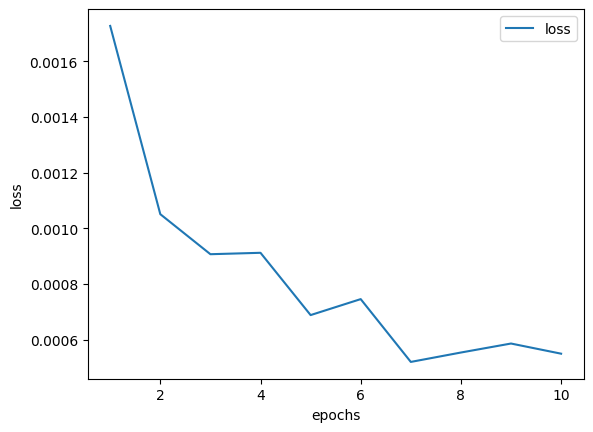

In [ ]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

<ipython-input-30-d63fbb9bd231>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


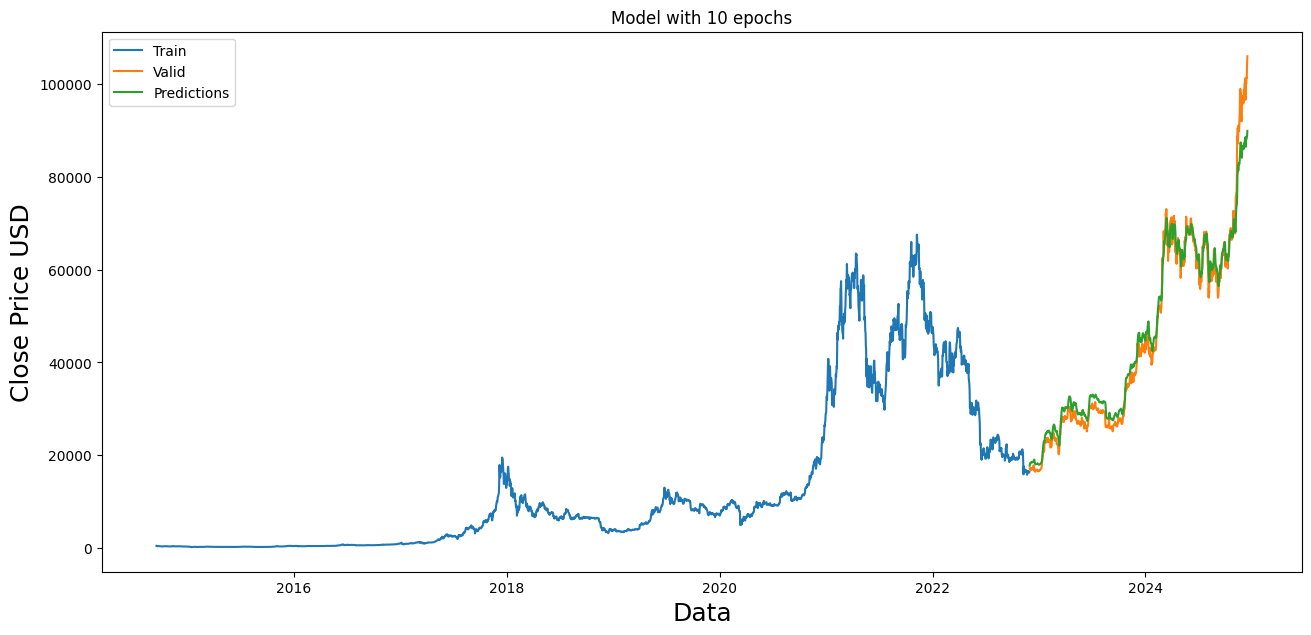

In [ ]:
# Plot the data
train = data[:training_data_len]

#data for model
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualized the data
#model
plt.figure(figsize=(15, 6))
plt.plot()
plt.title('Model with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

It seems our model did a good job with prediction today price. We might upgrade this model in the future together.

You can improve the model that we write together by doing these steps:

* Increase or decrease the hidden layers
* Increase or decrease the Units per each layer
* Using other types of layer or changing the activation function of the layers
* Train more the model with diffrent batch size and see what will happen

Don't forget that never change many items in your model, because you can't figure it out which of those changes will couse the improvment on to your model. And always using ploting and storing the history of training steps to see what is going on.

So here is the end of this notebook. I hope you did enjoy and learned something new.

Don't forget to give me a star if you like this model ;)